## Sequencing mixed extraction
In this notebook we explore the consequences of extracting sigantures from WGS and WES sequences simultaneously by including an additional 97th feature in the input data.

## Input data
Firstly, we need to load a combination of WES and WGS data, and combine it. This analysis is performed with the exomes from TCGA and the genomes from PCAWG. To get the sequencing feature to behave we standardize all counts features.

In [39]:
from functions import simulate_counts
import pandas as pd
import numpy as np

G_mat, G_sigs, _ = simulate_counts(4, 3000, sig_names = ['SBS17b', 'SBS10b', 'SBS2', 'SBS8'])
E_mat, E_sigs, _ = simulate_counts(4, 3000, sig_names = ['SBS17b', 'SBS10b', 'SBS2', 'SBS10a'])
# Denne her del får det til ikke at virke, hvilket ikke giver mening fordi den ikke ændrer noget efter normalisering - matematisk
# Det kan være det bare bliver for småt, så vi undlader det fordi det ikke har matematisk betydning
# E_mat = E_mat*0.1

G_mat = G_mat.T #(G_mat / G_mat.sum(axis=0)).T
G_mat['WGS'] = 1

E_mat = E_mat.T #(E_mat / E_mat.sum(axis=0)).T
E_mat['WGS'] = 0

total = pd.concat([E_mat, G_mat])


In [40]:

PCAWG = pd.read_csv(r'Q:\AUH-HAEM-FORSK-MutSigDLBCL222\external_data\Alexandrov_2020_synapse\WGS_PCAWG_2018_02_09\WGS_PCAWG.96.csv')
PCAWG.index = [t[0] + '[' + m + ']' + t[2] for (t,m) in zip(PCAWG['Trinucleotide'], PCAWG['Mutation type'])]
PCAWG = PCAWG.drop(['Trinucleotide', 'Mutation type'], axis = 1)

TCGA = pd.read_csv(r'Q:\AUH-HAEM-FORSK-MutSigDLBCL222\external_data\Alexandrov_2020_synapse\WES_TCGA_2018_03_09\WES_TCGA.96.csv')
TCGA.index = [t[0] + '[' + m + ']' + t[2] for (t,m) in zip(TCGA['Trinucleotide'], TCGA['Mutation type'])]
TCGA = TCGA.drop(['Trinucleotide', 'Mutation type'], axis = 1)

PCAWG = (PCAWG / PCAWG.sum(axis=0)).T
PCAWG['WGS'] = 1

TCGA = (TCGA / TCGA.sum(axis=0)).T
TCGA['WGS'] = 0 

total1 = pd.concat([PCAWG, TCGA])


## AAUtoSig model
The autoencoder model AAUtoSig needs to be updated to account for the additional feature.

In [41]:
import torch

class AAUtoSig(torch.nn.Module):
    def __init__(self, dim1):
        super().__init__()

        
        # Building an linear encoder
        # 96 => dim1 => dim2
        self.enc1 = torch.nn.Linear(97, dim1, bias = False)
          
        # Building an linear decoder 
        # dim2 => dim1 => 96
        self.dec2 = torch.nn.Linear(dim1, 97, bias = False)
            

    def forward(self, x):
        x = self.enc1(x)
        x = self.dec2(x)
        return x
        


## Excecuting the method
Now - lets run it on the dataset loaded above. In the current version of COSMIC (which is extracted on this data alongside other data sources) there are 78 signatures present - so this is the number we will extract in the following analysis. 

In [42]:
def train_AAUtoSig(epochs, model, x_train, loss_function, optimizer, batch_size):
    
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)

    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    for epoch in range(epochs):   
        model.train()
        
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)#.view(-1,96))
          nan_sum = reconstructed.detach().numpy().sum()
          if np.isnan(nan_sum):
            print("oops" + str(epoch))
          # Calculating the loss function
          loss = loss_function(reconstructed, data)#.view(-1,96))# + torch.mean(reconstructed) - torch.mean(data.view(-1,96))
          
          # The gradients are set to zero,
          # the the gradient is computed and stored.
          # .step() performs parameter update
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        with torch.no_grad():
            #print(model.dec2.weight)
            for p in model.dec2.weight:
                p.clamp_(min = 0)

    return(model)


model = AAUtoSig(5)    
    
loss_function = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),
                              lr = 1e-5)#,
                             #weight_decay = 1e-8)

train_AAUtoSig(epochs = 500, model = model, x_train = total1, loss_function = loss_function, 
                optimizer = optimizer, batch_size = 16)

sigs_est = model.dec2.weight.data
sigs_est = pd.DataFrame(sigs_est.numpy())#.iloc[:,0:5]

trinucleotide = total.columns
mutation =  [s[2:5] for s in trinucleotide[0:96]]
mutation.append('WGS')

sigs_est.index = trinucleotide

sigzzz = sigs_est

## Plots
Firstly we update the 'plotsigs' method to take the additional feature 'WGS'. Then we plot a lot of interesting things

In [43]:
import matplotlib.pyplot as plt
'''
def plotsigs(context, mutation, signatures, nsigs, title = "Super Seje Signaturer"):
    colors = {'C>A': 'r', 'C>G': 'b', 'C>T': 'g', 
                'T>A' : 'y', 'T>C': 'c','T>G' : 'm' , 'WGS': 'k'}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    for i in range(nsigs): signatures[0:96,i] = signatures[0:96,i]/np.sum(signatures[0:96,i])
    max_val = signatures.max().max()
    for i in range(nsigs):
        plt.subplot(nsigs,1, (i+1))
        #plt.figure(figsize=(20,7))
        plt.bar(x = context, 
                height =  signatures[:,i], 
                color = [colors[i] for i in mutation])
        plt.xticks([])
        plt.ylim( [ 0, max_val ] ) 
        if i == 0:
            plt.title(title)
    #plt.legend(handles,labels)
    plt.xticks(rotation=90)
    plt.show()
''' 

'\ndef plotsigs(context, mutation, signatures, nsigs, title = "Super Seje Signaturer"):\n    colors = {\'C>A\': \'r\', \'C>G\': \'b\', \'C>T\': \'g\', \n                \'T>A\' : \'y\', \'T>C\': \'c\',\'T>G\' : \'m\' , \'WGS\': \'k\'}\n    labels = list(colors.keys())\n    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]\n    for i in range(nsigs): signatures[0:96,i] = signatures[0:96,i]/np.sum(signatures[0:96,i])\n    max_val = signatures.max().max()\n    for i in range(nsigs):\n        plt.subplot(nsigs,1, (i+1))\n        #plt.figure(figsize=(20,7))\n        plt.bar(x = context, \n                height =  signatures[:,i], \n                color = [colors[i] for i in mutation])\n        plt.xticks([])\n        plt.ylim( [ 0, max_val ] ) \n        if i == 0:\n            plt.title(title)\n    #plt.legend(handles,labels)\n    plt.xticks(rotation=90)\n    plt.show()\n'

0.67999506


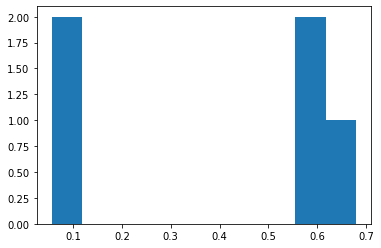

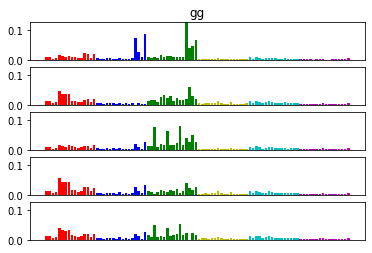

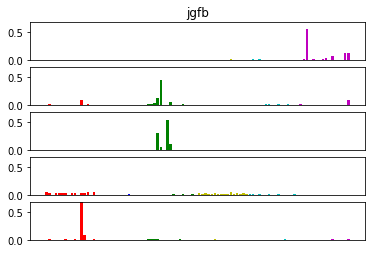

In [44]:
from functions import plotsigs, cosine_perm

sigs_est = sigzzz

sigs_true = pd.concat([G_sigs, E_sigs.iloc[:,-1]], axis = 1)
arg_max_WGS = np.argmax(sigs_est.iloc[96,:])
max_WGS = sigs_est.iloc[96,:].max()
print(max_WGS)
plt.hist(sigs_est.iloc[96,:])
plt.show()

perm = cosine_perm(sigs_est.drop(['WGS']).T, sigs_true.T)
sigs_est = sigs_est.iloc[0:96, perm[1]]


plotsigs(trinucleotide[0:96], mutation[0:96], sigs_est.to_numpy(), 5, "gg")
plotsigs(trinucleotide[0:96], mutation[0:96], sigs_true.to_numpy(), 5, "jgfb")

